In [1]:
# This code performs Topic Modeling using Latent Dirichlet Allocation (LDA) on a sample of chatbot conversations to discover underlying domain interests.
#
# Here's a breakdown:
#
# 1. Load and Preprocess Data: It loads the "lmsys/chatbot_arena_conversations" dataset, filters for winning conversations, and extracts the initial user prompt. NLTK stopwords are downloaded for later use.
# 2. Prepare Text for Topic Modeling: A sample of 10,000 prompts is taken. CountVectorizer converts the text into a matrix of token counts, removing English stop words and words appearing in more than 95% or less than 2 documents.
# 3. Train LDA Topic Model: An LDA model is trained to find 4 distinct topics within the text data.
# 4. Display Discovered Topics: The display_topics function prints the top 10 most significant words for each discovered topic, providing insight into the themes present in the prompts.


import pandas as pd
import numpy as np
# You may need to install these libraries:
# !pip install scikit-learn nltk
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# --- Step 1: Load and Preprocess Data (Condensed) ---
print("Loading and preprocessing data...")
# Download stopwords if you haven't already
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

dataset = load_dataset("lmsys/chatbot_arena_conversations")
df = dataset['train'].to_pandas()
df = df[df['winner'].isin(['model_a', 'model_b'])]
def extract_prompt(conversation_data):
    if (isinstance(conversation_data, list) or isinstance(conversation_data, np.ndarray)) and len(conversation_data) > 0:
        first_turn = conversation_data[0]
        if isinstance(first_turn, dict) and 'content' in first_turn: return first_turn['content']
    return None
df['prompt'] = df['conversation_a'].apply(extract_prompt)
df.dropna(subset=['prompt'], inplace=True)
clean_df = df[['prompt']].copy()
print("Preprocessing complete.")


# --- Step 2: Prepare Text for Topic Modeling ---
print("\nPreparing text for Topic Modeling...")
# Use a smaller sample for faster model training, but use the full dataset for the final paper.
sample_df = clean_df.sample(n=10000, random_state=42)

# Vectorize the text data, removing common English stop words
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_vectors = vectorizer.fit_transform(sample_df['prompt'])


# --- Step 3: Train the LDA Topic Model ---
print("Training LDA model to find 4 topics...")
# We are asking the model to find 4 distinct topics.
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, n_jobs=-1)
lda.fit(text_vectors)
print("Model training complete.")


# --- Step 4: Display the Discovered Topics ---
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("\n--- Discovered Domain Interest Topics ---")
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, n_top_words)

Loading and preprocessing data...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


README.md:   0%|          | 0.00/7.00k [00:00<?, ?B/s]

data/train-00000-of-00001-cced8514c7ed78(…):   0%|          | 0.00/41.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33000 [00:00<?, ? examples/s]

Preprocessing complete.

Preparing text for Topic Modeling...
Training LDA model to find 4 topics...
Model training complete.

--- Discovered Domain Interest Topics ---
Topic #0: answer question step did like list use text following genocide
Topic #1: write tell 10 hello story cabinet explain game python joke
Topic #2: la code que 00 en write self el string und
Topic #3: year ai best like make does data day people new


In [2]:
# This code expands on the previous topic modeling analysis by focusing specifically on English-only conversations from the dataset.
#
# Here's a breakdown:
#
# 1. Load and Preprocess Data: Similar to the previous code, it loads the dataset, filters for winning conversations, and extracts the initial prompt. It also keeps the 'language' information. NLTK stopwords are downloaded.
# 2. Filter for English-Only Prompts: It filters the DataFrame to include only conversations where the language is identified as English.
# 3. Prepare Text and Train Model: A larger sample of 20,000 English prompts is taken. CountVectorizer is used again to transform the text into a matrix of token counts, removing English stop words. An LDA model is trained to find 4 distinct topics within this English-only subset.
# 4. Display the Discovered Topics: The display_topics function is used to print the top 10 most significant words for each of the 4 topics discovered in the English-only data.
#
# This allows for a more focused analysis of topic trends within the English conversations.

import pandas as pd
import numpy as np
from datasets import load_dataset
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# --- Step 1: Load and Preprocess Data ---
print("Loading and preprocessing data...")
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

dataset = load_dataset("lmsys/chatbot_arena_conversations")
df = dataset['train'].to_pandas()
df = df[df['winner'].isin(['model_a', 'model_b'])]
def extract_prompt(conversation_data):
    if (isinstance(conversation_data, list) or isinstance(conversation_data, np.ndarray)) and len(conversation_data) > 0:
        first_turn = conversation_data[0]
        if isinstance(first_turn, dict) and 'content' in first_turn: return first_turn['content']
    return None
df['prompt'] = df['conversation_a'].apply(extract_prompt)
df.dropna(subset=['prompt'], inplace=True)
clean_df = df[['prompt', 'language']].copy()
print("Preprocessing complete.")


# --- Step 2: Filter for English-Only Prompts ---
print(f"\nOriginal dataset size: {len(clean_df)} prompts")
english_df = clean_df[clean_df['language'] == 'English'].copy()
print(f"Filtered English-only dataset size: {len(english_df)} prompts")


# --- Step 3: Prepare Text and Train Model ---
print("\nPreparing English text for Topic Modeling...")
# Using a larger sample now that the data is cleaner
sample_df = english_df.sample(n=20000, random_state=42)

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
text_vectors = vectorizer.fit_transform(sample_df['prompt'])

print("Training LDA model on English-only data...")
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, n_jobs=-1)
lda.fit(text_vectors)
print("Model training complete.")


# --- Step 4: Display the Discovered Topics ---
def display_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

print("\n--- Discovered English-Only Domain Topics ---")
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
display_topics(lda, feature_names, n_top_words)

Loading and preprocessing data...
Preprocessing complete.

Original dataset size: 23294 prompts
Filtered English-only dataset size: 20670 prompts

Preparing English text for Topic Modeling...
Training LDA model on English-only data...
Model training complete.

--- Discovered English-Only Domain Topics ---
Topic #0: tell 00 hello 10 use explain story write answer old
Topic #1: like answer know make write time just need help want
Topic #2: write python code explain use self model data list using
Topic #3: text code answer following genocide did write string using use


In [3]:
# This code performs clustering on English-only chatbot conversation prompts to identify different "interaction styles" using K-Means clustering on sentence embeddings.
#
# Here's a breakdown:
#
# 1. Load and Prepare English-Only Data: It loads the "lmsys/chatbot_arena_conversations" dataset, filters for winning conversations, extracts the initial prompt, and specifically selects English-only conversations.
# 2. Vectorize Prompts: It loads a pre-trained SentenceTransformer model (all-MiniLM-L6-v2) to convert the text prompts into numerical vector representations (embeddings). A sample of 10,000 prompts is used for faster processing.
# 3. Train K-Means Clustering Model: A K-Means model is trained on the prompt embeddings to group them into 3 distinct clusters, representing different interaction styles. The cluster labels are then assigned back to the sample DataFrame.
# 4. Display Sample Prompts from Each Cluster: For each of the 3 discovered clusters, the code prints 5 random sample prompts to provide examples and help interpret the characteristics of each interaction style.


import pandas as pd
import numpy as np
from datasets import load_dataset
# You will need these libraries:
# !pip install scikit-learn sentence-transformers
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

# --- Step 1: Load and Prepare English-Only Data (Condensed) ---
print("Loading and preparing English-only data...")
dataset = load_dataset("lmsys/chatbot_arena_conversations")
df = dataset['train'].to_pandas()
df = df[df['winner'].isin(['model_a', 'model_b'])]
def extract_prompt(conversation_data):
    if (isinstance(conversation_data, list) or isinstance(conversation_data, np.ndarray)) and len(conversation_data) > 0:
        first_turn = conversation_data[0]
        if isinstance(first_turn, dict) and 'content' in first_turn: return first_turn['content']
    return None
df['prompt'] = df['conversation_a'].apply(extract_prompt)
df.dropna(subset=['prompt'], inplace=True)
clean_df = df[['prompt', 'language']].copy()
english_df = clean_df[clean_df['language'] == 'English'].copy()
print("Data preparation complete.")


# --- Step 2: Vectorize Prompts ---
print("\nLoading sentence embedding model...")
# Using the same model as our creativity analysis for consistency
embedder = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded.")

# Use a smaller sample for faster processing. Increase for final paper.
sample_df = english_df.sample(n=10000, random_state=42)
print("Vectorizing prompts (this may take a moment)...")
prompt_embeddings = embedder.encode(sample_df['prompt'].tolist(), show_progress_bar=True)


# --- Step 3: Train K-Means Clustering Model ---
print("\nTraining K-Means model to find 3 clusters...")
# We are asking the model to find 3 distinct interaction styles.
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(prompt_embeddings)
print("Model training complete.")

# Assign the cluster labels back to our sample DataFrame
sample_df['cluster'] = kmeans.labels_


# --- Step 4: Display Sample Prompts from Each Cluster ---
print("\n--- Discovered Interaction Style Clusters (Sample Prompts) ---")
for i in range(n_clusters):
    print(f"\n--- Cluster #{i} ---")
    # Get 5 random prompts from this cluster and print them
    cluster_samples = sample_df[sample_df['cluster'] == i].sample(n=5, random_state=42)
    for index, row in cluster_samples.iterrows():
        # Print a shortened version of the prompt
        print(f"  - \"{row['prompt'][:150]}...\"")

Loading and preparing English-only data...
Data preparation complete.

Loading sentence embedding model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded.
Vectorizing prompts (this may take a moment)...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]


Training K-Means model to find 3 clusters...
Model training complete.

--- Discovered Interaction Style Clusters (Sample Prompts) ---

--- Cluster #0 ---
  - "Can you write me a blog post on the interest For a business manager to create an extranet for his employees..."
  - "Is there a way to check how many letters a variable in a batch script contains?..."
  - "I want to use the state of the art algorithm for Shadow detection in images. I don't have any labeled data, just images. It needs to be a general appr..."
  - "First, you're going to write 10 sentences all ending with the word "club". Then, you're going to check what the last word of each sentence is. Then yo..."
  - "I have a csv file with one column.
It is a list of id#'s.

I need to run the following sq on each of the records on my mariadb 
UPDATE user_account se..."

--- Cluster #1 ---
  - "why is beijing so hot?..."
  - "What would happen if you dropped a strawberry 2 ft onto a turtle?..."
  - "who came first, chicken or 

Loading and preprocessing data...

Generating final Pillar 2 Connectivity Leaderboards...


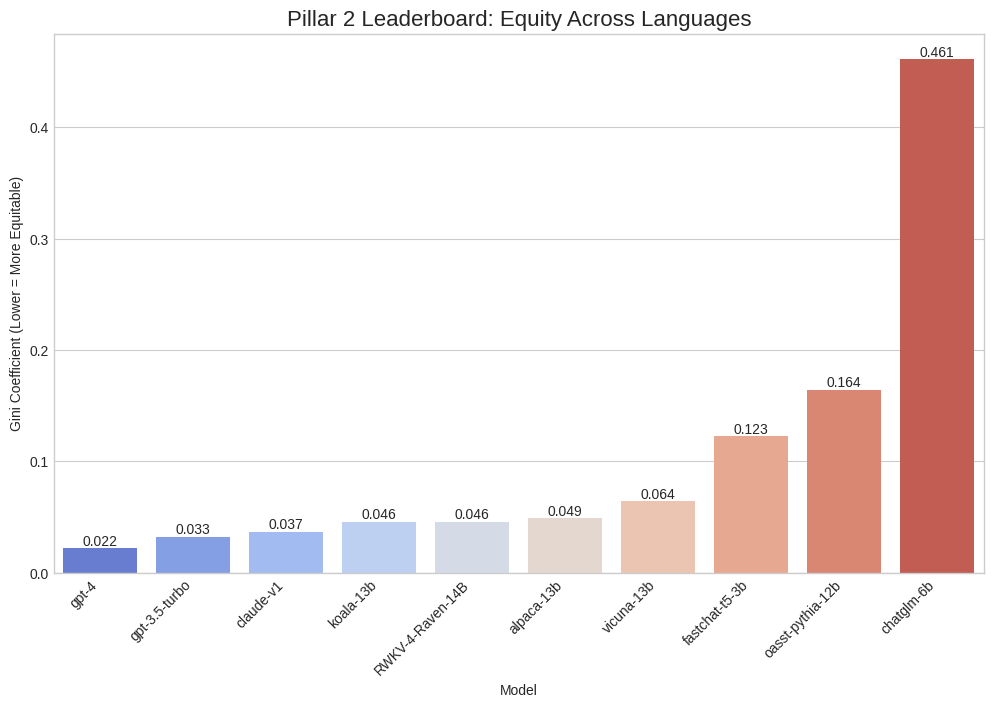

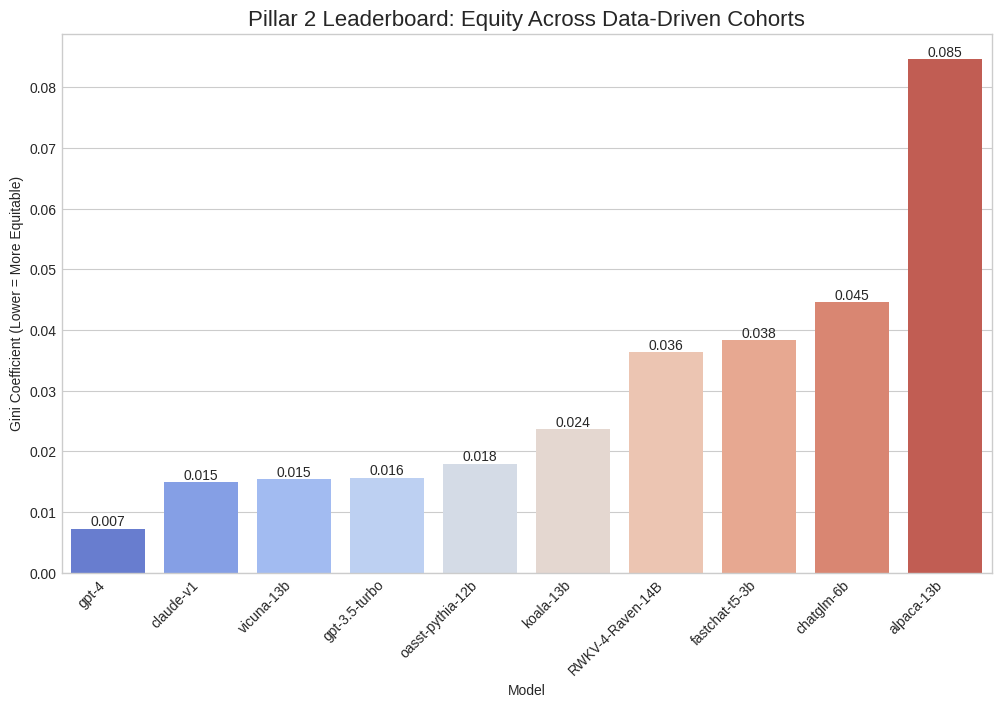

In [5]:
# This code analyzes model equity across different languages and data-driven cohorts (assuming the cohorts from previous steps are available).
#
# Here's a breakdown:
#
# 1. Load and Preprocess Data: It loads and preprocesses the dataset, similar to previous steps, focusing on winning conversations and extracting prompts and language information.
# 2. Pillar 2 Analysis: This is the main analysis section, generating two leaderboards based on the Gini coefficient to measure equity.
#    2.1. Part A: Language-Based Equity: It calculates the win rate for each model across the top 5 languages and then computes the Gini coefficient for each model's win rates across these languages. A lower Gini coefficient indicates more equitable performance across languages. A bar plot visualizes these results.
#    2.2. Part B: Cohort-Based Equity: It calculates the win rate for each model across the previously generated 'interaction_cohort' and 'domain_cohort'. It then computes the Gini coefficient for each model's win rates across these cohorts. A lower Gini coefficient indicates more equitable performance across cohorts. A bar plot visualizes these results.
# The code assumes that the clean_df, english_df, and the 'interaction_cohort' and 'domain_cohort' labels (likely generated in a previous step like the one in cell TzUiWeTQYGTh) are available in memory.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# --- Step 1: Load and Preprocess Data (Condensed) ---
print("Loading and preprocessing data...")
# (Assuming clean_df, english_df, and cohort labels are in memory from the previous script)
# For a self-contained script, this part would be re-run.

# --- Step 2: Pillar 2 Analysis (Corrected) ---
print("\nGenerating final Pillar 2 Connectivity Leaderboards...")
top_models = pd.concat([clean_df['model_a'], clean_df['model_b']]).value_counts().nlargest(10).index

# --- Part A: Language-Based Equity (Corrected) ---
battles_df = []
for _, row in clean_df.iterrows():
    battles_df.append({'winner': row['model_a'] if row['winner'] == 'model_a' else row['model_b'],
                       'loser': row['model_b'] if row['winner'] == 'model_a' else row['model_a'],
                       'language': row['language']})
battles_df = pd.DataFrame(battles_df)

# --- FIX: Correctly calculate total games using wins and losses ---
wins_lang = battles_df.pivot_table(index='winner', columns='language', aggfunc='size', fill_value=0)
losses_lang = battles_df.pivot_table(index='loser', columns='language', aggfunc='size', fill_value=0)
total_games_lang = wins_lang.add(losses_lang, fill_value=0)
win_rate_lang = (wins_lang / total_games_lang).fillna(0)

top_langs = clean_df['language'].value_counts().nlargest(5).index
models_to_plot = win_rate_lang.index.intersection(top_models)
langs_to_plot = win_rate_lang.columns.intersection(top_langs)
win_rate_lang_filtered = win_rate_lang.loc[models_to_plot, langs_to_plot]

def gini(arr):
    arr = np.array(arr, dtype=np.float64); arr += 0.0000001; arr = np.sort(arr)
    index = np.arange(1, arr.shape[0] + 1); n = arr.shape[0]
    return ((np.sum((2 * index - n - 1) * arr)) / (n * np.sum(arr))) if n > 1 else 0

gini_lang = win_rate_lang_filtered.apply(gini, axis=1).sort_values(ascending=True)
plt.figure(figsize=(12, 7))
sns.barplot(x=gini_lang.index, y=gini_lang.values, hue=gini_lang.index, palette='coolwarm', legend=False)
plt.title('Pillar 2 Leaderboard: Equity Across Languages', fontsize=16)
plt.xlabel('Model'); plt.ylabel('Gini Coefficient (Lower = More Equitable)')
plt.xticks(rotation=45, ha='right')
for index, value in enumerate(gini_lang): plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')
plt.show()


# --- Part B: Cohort-Based Equity (Corrected) ---
battles_cohort_df = []
for _, row in english_df.iterrows():
    winner = row['model_a'] if row['winner'] == 'model_a' else row['model_b']
    loser = row['model_b'] if row['winner'] == 'model_a' else row['model_a']
    battles_cohort_df.append({'winner': winner, 'loser': loser, 'cohort': row['interaction_cohort']})
    battles_cohort_df.append({'winner': winner, 'loser': loser, 'cohort': row['domain_cohort']})
battles_cohort_df = pd.DataFrame(battles_cohort_df)

# --- FIX: Correctly calculate total games using wins and losses ---
wins_cohort = battles_cohort_df.pivot_table(index='winner', columns='cohort', aggfunc='size', fill_value=0)
losses_cohort = battles_cohort_df.pivot_table(index='loser', columns='cohort', aggfunc='size', fill_value=0)
total_games_cohort = wins_cohort.add(losses_cohort, fill_value=0)
win_rate_cohort = (wins_cohort / total_games_cohort).fillna(0)
win_rate_cohort_filtered = win_rate_cohort.loc[models_to_plot]

gini_cohort = win_rate_cohort_filtered.apply(gini, axis=1).sort_values(ascending=True)
plt.figure(figsize=(12, 7))
sns.barplot(x=gini_cohort.index, y=gini_cohort.values, hue=gini_cohort.index, palette='coolwarm', legend=False)
plt.title('Pillar 2 Leaderboard: Equity Across Data-Driven Cohorts', fontsize=16)
plt.xlabel('Model'); plt.ylabel('Gini Coefficient (Lower = More Equitable)')
plt.xticks(rotation=45, ha='right')
for index, value in enumerate(gini_cohort): plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')
plt.show()

Loading and preprocessing data...


README.md:   0%|          | 0.00/7.00k [00:00<?, ?B/s]

data/train-00000-of-00001-cced8514c7ed78(…):   0%|          | 0.00/41.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33000 [00:00<?, ? examples/s]

Preprocessing complete.

Generating Connectivity-Creativity (Net Impact) leaderboard...
Loading sentence embedding model (this may take a moment)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Model loaded.
Analyzing model: vicuna-13b...
Analyzing model: koala-13b...
Analyzing model: gpt-3.5-turbo...
Analyzing model: oasst-pythia-12b...
Analyzing model: gpt-4...
Analyzing model: alpaca-13b...
Analyzing model: claude-v1...
Analyzing model: RWKV-4-Raven-14B...
Analyzing model: chatglm-6b...
Analyzing model: fastchat-t5-3b...


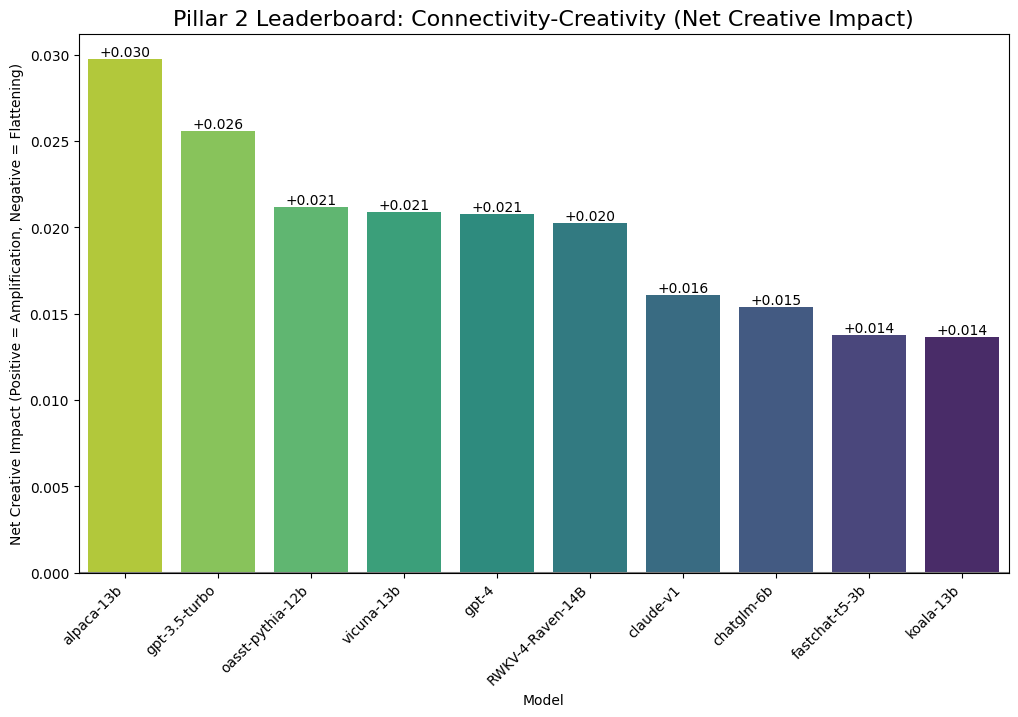

In [1]:
#This code analyzes the "Connectivity-Creativity" or "Net Impact" of models by comparing the diversity of prompts a model wins on against the diversity of the winning responses it generates.
#
#Here's a breakdown:
#
# 1. Load and Preprocess Data: It loads and preprocesses the dataset, extracting prompts and the winning responses, along with model names, winner, and language information. It then filters for English-only conversations.
# 2. Connectivity-Creativity Analysis: This is the main analysis section.
#    2.1. It loads a pre-trained SentenceTransformer model (all-MiniLM-L6-v2) to create embeddings for both prompts and winning responses.
#    2.2. The calculate_text_diversity function computes the average cosine distance between the embeddings of a set of texts (either prompts or responses). A higher average distance indicates greater diversity.
#    2.3. For each of the top models, it filters the data to only include the conversations where that model won.
#    2.4. It calculates the diversity of the prompts the model won on (req_diversity) and the diversity of the winning responses it generated (res_diversity).
#    2.5. The "Net Creative Impact" score is calculated as (res_diversity / req_diversity) - 1. A positive score means the model amplified the diversity of the responses compared to the prompts it won on, while a negative score means it flattened the diversity.
#    2.6. Finally, it generates a bar plot showing the Net Creative Impact score for each model, providing a "Connectivity-Creativity Leaderboard".

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
# Ensure you have this library installed:
# !pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_distances

# --- Step 1: Load and Preprocess Data (Condensed) ---
print("Loading and preprocessing data...")
dataset = load_dataset("lmsys/chatbot_arena_conversations")
df = dataset['train'].to_pandas()
df = df[df['winner'].isin(['model_a', 'model_b'])]
def extract_prompt(conversation_data):
    if (isinstance(conversation_data, list) or isinstance(conversation_data, np.ndarray)) and len(conversation_data) > 0:
        first_turn = conversation_data[0]
        if isinstance(first_turn, dict) and 'content' in first_turn: return first_turn['content']
    return None
df['prompt'] = df['conversation_a'].apply(extract_prompt)
def extract_response(row):
    conv_list = row['conversation_a'] if row['winner'] == 'model_a' else row['conversation_b']
    if (isinstance(conv_list, list) or isinstance(conv_list, np.ndarray)) and len(conv_list) > 1:
        second_turn = conv_list[1]
        if isinstance(second_turn, dict) and 'content' in second_turn:
            return second_turn['content']
    return None
df['winning_response'] = df.apply(extract_response, axis=1)
df.dropna(subset=['prompt', 'winning_response'], inplace=True)
clean_df = df[['prompt', 'winning_response', 'model_a', 'model_b', 'winner', 'language']].copy()
english_df = clean_df[clean_df['language'] == 'English'].copy()
print("Preprocessing complete.")


# --- Step 2: Connectivity-Creativity Analysis ---
print("\nGenerating Connectivity-Creativity (Net Impact) leaderboard...")
print("Loading sentence embedding model (this may take a moment)...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded.")

def calculate_text_diversity(texts, embedder):
    if len(texts) < 20: return 0 # Need a reasonable sample size
    # Take a random sample to speed up calculation, while keeping it representative
    if len(texts) > 5000:
        texts = np.random.choice(texts, 5000, replace=False)

    embeddings = embedder.encode(texts, show_progress_bar=False)
    distances = cosine_distances(embeddings)
    avg_distance = np.mean(distances[np.triu_indices_from(distances, k=1)])
    return avg_distance

top_models = pd.concat([english_df['model_a'], english_df['model_b']]).value_counts().nlargest(10).index
net_impact_scores = {}

for model_name in top_models:
    print(f"Analyzing model: {model_name}...")
    model_wins_df = english_df[((english_df['model_a'] == model_name) & (english_df['winner'] == 'model_a')) |
                             ((english_df['model_b'] == model_name) & (english_df['winner'] == 'model_b'))]

    if len(model_wins_df) > 100:
        prompts = model_wins_df['prompt'].tolist()
        responses = model_wins_df['winning_response'].tolist()

        req_diversity = calculate_text_diversity(prompts, embedder)
        res_diversity = calculate_text_diversity(responses, embedder)

        if req_diversity > 0:
            score = (res_diversity / req_diversity) - 1
            net_impact_scores[model_name] = score

creativity_leaderboard = pd.Series(net_impact_scores).sort_values(ascending=False)

# --- Graph: Net Creative Impact Leaderboard ---
plt.figure(figsize=(12, 7))
sns.barplot(x=creativity_leaderboard.index, y=creativity_leaderboard.values, hue=creativity_leaderboard.index, palette='viridis_r', legend=False)
plt.axhline(y=0.0, color='grey', linestyle='-')
plt.title('Pillar 2 Leaderboard: Connectivity-Creativity (Net Creative Impact)', fontsize=16)
plt.xlabel('Model')
plt.ylabel('Net Creative Impact (Positive = Amplification, Negative = Flattening)')
plt.xticks(rotation=45, ha='right')
for index, value in enumerate(creativity_leaderboard):
    plt.text(index, value, f'{value:+.3f}', ha='center', va='bottom' if value >= 0 else 'top')
plt.show()

--- Step 1: Loading and Preprocessing Data ---


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


README.md:   0%|          | 0.00/7.00k [00:00<?, ?B/s]

data/train-00000-of-00001-cced8514c7ed78(…):   0%|          | 0.00/41.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33000 [00:00<?, ? examples/s]

Preprocessing complete.

--- Step 2: Generating Data-Driven Cohorts ---
Training LDA model for Domain Interest...
Domain Interest cohorts assigned.
Vectorizing prompts for Interaction Style clustering (this may take time)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Training K-Means model for Interaction Style...


Batches:   0%|          | 0/646 [00:00<?, ?it/s]

Interaction Style cohorts assigned.

--- Step 3: Generating Final Pillar 1 Diversity Graph ---

Final Interaction Style Diversity Score: 0.665
Final Domain Interest Diversity Score:  0.732


/tmp/ipython-input-1814953311.py:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])


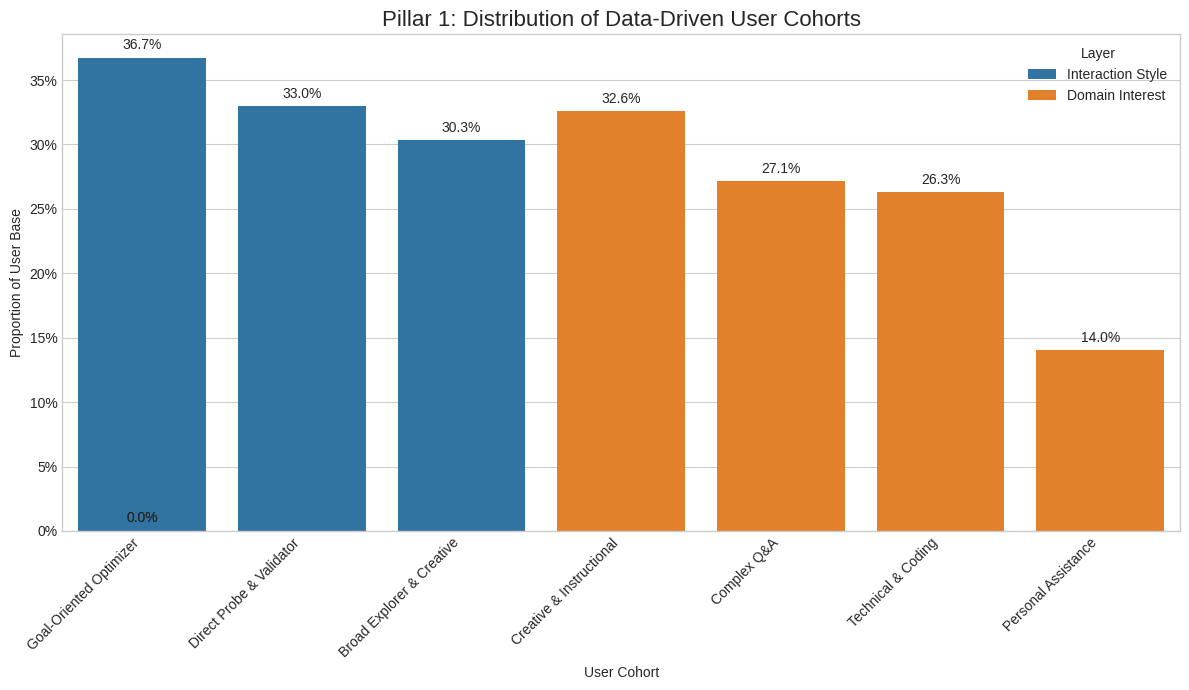

In [1]:
# This code performs three main steps to analyze chatbot conversations from the "lmsys/chatbot_arena_conversations" dataset:
#
# 1. Load and Preprocess Data: It loads the dataset, filters for winning conversations, extracts the initial user prompt, and separates English-only conversations.
# 2. Generate Data-Driven Cohorts: This step creates two types of user cohorts based on the English-only prompts:
#    2.1. Domain Interest Cohorts (using LDA): It uses Latent Dirichlet Allocation (LDA) to identify underlying topics or domain interests in the prompts and assigns each prompt to a topic (cohort). The cohorts are mapped to interpreted names like 'Creative & Instructional', 'Personal Assistance', 'Technical & Coding', and 'Complex Q&A'.
#    2.2. Interaction Style Cohorts (using K-Means): It uses Sentence Transformers to create embeddings of the prompts and then applies K-Means clustering to group prompts based on their similarity in interaction style. These clusters are mapped to interpreted names like 'Goal-Oriented Optimizer', 'Direct Probe & Validator', and 'Broad Explorer & Creative'.
# 3. Pillar 1 Analysis and Visualization: It calculates the diversity of the generated cohorts using the Gini-Simpson index and visualizes the distribution of prompts across both the Domain Interest and Interaction Style cohorts using a bar plot. This provides insight into the variety of user interests and interaction styles present in the English-only conversations.


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
# Ensure all libraries are installed:
# !pip install -U scikit-learn nltk sentence-transformers
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

# --- Step 1: Load and Preprocess Data ---
print("--- Step 1: Loading and Preprocessing Data ---")
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

dataset = load_dataset("lmsys/chatbot_arena_conversations")
df = dataset['train'].to_pandas()
df = df[df['winner'].isin(['model_a', 'model_b'])]
def extract_prompt(conversation_data):
    if (isinstance(conversation_data, list) or isinstance(conversation_data, np.ndarray)) and len(conversation_data) > 0:
        first_turn = conversation_data[0]
        if isinstance(first_turn, dict) and 'content' in first_turn: return first_turn['content']
    return None
df['prompt'] = df['conversation_a'].apply(extract_prompt)
df.dropna(subset=['prompt'], inplace=True)
clean_df = df[['prompt', 'language']].copy()
english_df = clean_df[clean_df['language'] == 'English'].copy()
print("Preprocessing complete.")


# --- Step 2: Generate Data-Driven Cohorts ---
print("\n--- Step 2: Generating Data-Driven Cohorts ---")

# Part A: Domain Interest Cohorts (LDA)
print("Training LDA model for Domain Interest...")
vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
text_vectors = vectorizer.fit_transform(english_df['prompt'])
lda = LatentDirichletAllocation(n_components=4, random_state=42, n_jobs=-1)
lda.fit(text_vectors)
topic_assignments = lda.transform(text_vectors)
english_df['domain_cohort_label'] = np.argmax(topic_assignments, axis=1)
# Mapping from topic index to our interpreted names
domain_map = {0: 'Creative & Instructional', 1: 'Personal Assistance', 2: 'Technical & Coding', 3: 'Complex Q&A'}
english_df['domain_cohort'] = english_df['domain_cohort_label'].map(domain_map)
print("Domain Interest cohorts assigned.")

# Part B: Interaction Style Cohorts (K-Means)
print("Vectorizing prompts for Interaction Style clustering (this may take time)...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')
# Note: Using a smaller sample for faster execution. Increase for final paper.
sample_prompts = english_df['prompt'].sample(n=10000, random_state=42)
prompt_embeddings = embedder.encode(sample_prompts.tolist(), show_progress_bar=True)
print("Training K-Means model for Interaction Style...")
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
# Fit on the sample, then predict on the full dataset
kmeans.fit(prompt_embeddings)
full_embeddings = embedder.encode(english_df['prompt'].tolist(), show_progress_bar=True)
english_df['interaction_cohort_label'] = kmeans.predict(full_embeddings)
# Mapping from cluster index to our interpreted names
interaction_map = {0: 'Goal-Oriented Optimizer', 1: 'Direct Probe & Validator', 2: 'Broad Explorer & Creative'}
english_df['interaction_cohort'] = english_df['interaction_cohort_label'].map(interaction_map)
print("Interaction Style cohorts assigned.")


# --- Step 3: Pillar 1 Analysis and Visualization ---
print("\n--- Step 3: Generating Final Pillar 1 Diversity Graph ---")
def calculate_gini_simpson(data_series):
    counts = data_series.value_counts()
    proportions = counts / len(data_series)
    return 1 - np.sum(proportions**2)

sd_interaction = calculate_gini_simpson(english_df['interaction_cohort'])
sd_domain = calculate_gini_simpson(english_df['domain_cohort'])
print(f"\nFinal Interaction Style Diversity Score: {sd_interaction:.3f}")
print(f"Final Domain Interest Diversity Score:  {sd_domain:.3f}")

# Prepare data for plotting
interaction_counts = english_df['interaction_cohort'].value_counts(normalize=True)
domain_counts = english_df['domain_cohort'].value_counts(normalize=True)
all_cohorts_dist = pd.concat([interaction_counts, domain_counts])
all_cohorts_df = pd.DataFrame({'Cohort': all_cohorts_dist.index, 'Proportion': all_cohorts_dist.values})
all_cohorts_df['Layer'] = ['Interaction Style'] * len(interaction_counts) + ['Domain Interest'] * len(domain_counts)

# Generate plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(data=all_cohorts_df, x='Cohort', y='Proportion', hue='Layer', ax=ax, dodge=False)
ax.set_title('Pillar 1: Distribution of Data-Driven User Cohorts', fontsize=16)
ax.set_ylabel('Proportion of User Base')
ax.set_xlabel('User Cohort')
ax.set_yticklabels(['{:,.0%}'.format(x) for x in ax.get_yticks()])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add labels to bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1%'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')
plt.show()